## Importing modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from sklearn.datasets import load_iris
from fcmeans import FCM

## Load data

In [2]:
data = load_iris()

X = data["data"]
y = data["target"]

labels = data["target_names"]
y_labels = [labels[i] for i in y]

features = data["feature_names"]

n_clusters = len(labels)
n_features = len(features)

## Data visualization

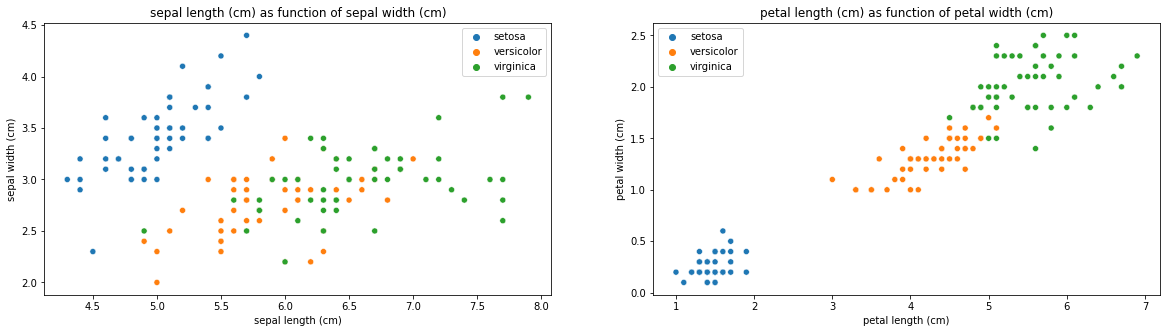

In [3]:
plt.figure(figsize=(20,5))

n_plot=1
for i in range(0, len(features), 2):
    plt.subplot(1, 2, n_plot)
    sbn.scatterplot(x=X[:,i], y=X[:,i+1], hue=y_labels)
    plt.xlabel(features[i])
    plt.ylabel(features[i+1])
    plt.title(f"{features[i]} as function of {features[i+1]}")
    n_plot += 1

plt.show()

## Fuzzy

In [36]:
fcm = FCM(n_clusters=n_clusters)
fcm.fit(X)
soft_pred = fcm.soft_predict(X)

In [38]:
hard_pred = []
for line in soft_pred:
    if ((line > 0.8).any()):
        hard_pred.append(np.argmax(line))
    else:
        hard_pred.append(3)

In [65]:
new_labels = labels.tolist()
new_labels.append("Incertain")
labels_pred = [new_labels[i] for i in hard_pred]

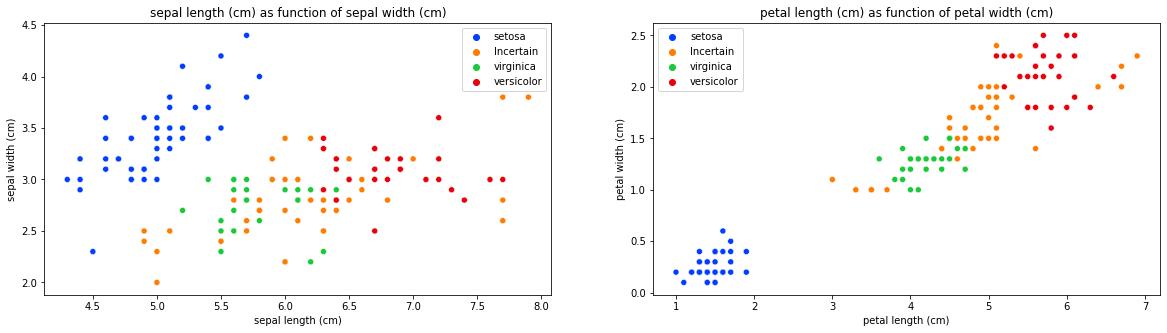

In [66]:
plt.figure(figsize=(20,5))

n_plot=1
for i in range(0, len(features), 2):
    plt.subplot(1, 2, n_plot)
    sbn.scatterplot(x=X[:,i], y=X[:,i+1], hue=labels_pred, palette=sbn.color_palette("bright")[:len(features)])
    plt.xlabel(features[i])
    plt.ylabel(features[i+1])
    plt.title(f"{features[i]} as function of {features[i+1]}")
    n_plot += 1

plt.show()